In [1]:
%matplotlib inline
import stereo as st 
import matplotlib.pyplot as plt
import seaborn

# plot func

## plot_spatial_cluster

In [2]:
from anndata import AnnData

from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap, to_hex
from matplotlib import gridspec
import numpy as np
import pandas as pd


def scatter(
        x: list,
        y: list,
        ax: Axes = None,
        dot_colors=None,
        marker=".",
        dot_size=1,
        cmap=None,
        plotnonfinite=True,
        **kwargs
):
    """
    Simplified scatter plot function, which wraps matplotlib.axes.Axes.scatter .
    :param x,y: Data position list.
    :param ax: plot axes.
    :param color: list of colors.
    :param marker: marker type.
    :param size: marker size.
    :param cmap: Color map.
    :param plotnonfinite: whether to plot bad point.
    :return: plot axes.
    """

    if (len(x) <= 0 or len(y) <= 0):
        print("x position or y position has no data.")
    if dot_colors is None:
        dot_colors = ["gray"]
    if (isinstance(dot_colors, str)):
        dot_colors = [dot_colors]

    if (ax == None):
        fig = plt.figure()
        ax = fig.add_subplot(111)
    if (cmap == None):
        cmap = get_cmap()

    pathcollection = ax.scatter(
        x, y,
        c=dot_colors,
        marker=marker,
        s=dot_size,
        cmap=cmap,
        plotnonfinite=plotnonfinite,
        **kwargs,
    )

    return pathcollection


def plot_cluster_result(
        adata: AnnData,
        obs_key: list = ["phenograph"],
        pos_key="spatial",
        plot_cluster: list = None,
        bad_color="lightgrey",
        ncols=2,
        dot_size=None,
        invert_y=False,
        color_list=['violet', 'turquoise', 'tomato', 'teal',
                    'tan', 'silver', 'sienna', 'red', 'purple',
                    'plum', 'pink', 'orchid', 'orangered', 'orange',
                    'olive', 'navy', 'maroon', 'magenta', 'lime',
                    'lightgreen', 'lightblue', 'lavender', 'khaki',
                    'indigo', 'grey', 'green', 'gold', 'fuchsia',
                    'darkgreen', 'darkblue', 'cyan', 'crimson', 'coral',
                    'chocolate', 'chartreuse', 'brown', 'blue', 'black',
                    'beige', 'azure', 'aquamarine', 'aqua',
                    ],
):  # scatter plot, 聚类后表达矩阵空间分布
    """
    Plot spatial distribution of specified obs data.
    ============ Arguments ============
    :param adata: AnnData object.
    :param obs_key: specified obs cluster key list, for example: ["phenograph"].
    :param pos_key: the coordinates of data points for scatter plots. the data points are stored in adata.obsm[pos_key]. choice: "spatial", "X_umap", "X_pca".
    :param plot_cluster: the name list of clusters to show.
    :param ncols: numbr of plot columns.
    :param dot_size: marker size.
    :param cmap: Color map.
    :param invert_y: whether to invert y-axis.
    ============ Return ============
    None.
    ============ Example ============
    plot_spatial_cluster(adata = adata)
    """
    # sc.pl.embedding(adata, basis="spatial", color=["total_counts", "n_genes_by_counts"],size=30)

    if dot_size is None:
        dot_size = 120000 / adata.shape[0]

    ncols = min(ncols, len(obs_key))
    nrows = np.ceil(len(obs_key) / ncols).astype(int)
    # each panel will have the size of rcParams['figure.figsize']
    fig = plt.figure(figsize=(ncols * 10, nrows * 8))
    left = 0.2 / ncols
    bottom = 0.13 / nrows
    axs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        left=left,
        right=1 - (ncols - 1) * left - 0.01 / ncols,
        bottom=bottom,
        top=1 - (nrows - 1) * bottom - 0.1 / nrows,
        # hspace=hspace,
        # wspace=wspace,
    )

    if color_list is None:
        cmap = get_cmap()
    else:
        cmap = ListedColormap(color_list)
    cmap.set_bad(bad_color)
    # 把特定值改为 np.nan 之后，可以利用 cmap.set_bad("white") 来遮盖掉这部分数据

    for i, key in enumerate(obs_key):
        # color_data = adata.obs_vector(key)  # TODO  replace by get_cluster_res
        color_data = get_cluster_res(adata, data_key=key)
        pcLogic = False

        # color_data = np.asarray(color_data_raw, dtype=float)
        order = np.argsort(~pd.isnull(color_data), kind="stable")
#         spatial_data = np.array(adata.obsm[pos_key])[:, 0: 2]
        spatial_data = get_reduce_x(data=adata, data_key=pos_key)[:, 0:2]
        color_data = color_data[order]
        spatial_data = spatial_data[order, :]

        color_dict = {}
        has_na = False
        if pd.api.types.is_categorical_dtype(color_data):
            pcLogic = True
            if plot_cluster is None:
                plot_cluster = list(color_data.categories)
        if pcLogic:
            clusterN = len(np.unique(color_data))
            if len(color_list) < clusterN:
                color_list = color_list * clusterN
                cmap = ListedColormap(color_list)
                cmap.set_bad(bad_color)
            if (len(color_data.categories) > len(plot_cluster)):
                color_data = color_data.replace(color_data.categories.difference(plot_cluster), np.nan)
                has_na = True
            color_dict = {str(k): to_hex(v) for k, v in enumerate(color_list)}
            print(color_dict)
            color_data = color_data.map(color_dict)
            if (pd.api.types.is_categorical_dtype(color_data)):
                color_data = pd.Categorical(color_data)
            if has_na:
                color_data = color_data.add_categories([to_hex(bad_color)])
                color_data = color_data.fillna(to_hex(bad_color))
                # color_dict["NA"]

        # color_data 是图像中各个点的值，也对应了每个点的颜色。data_points则对应了各个点的坐标
        ax = fig.add_subplot(axs[i])  # ax = plt.subplot(axs[i]) || ax = fig.add_subplot(axs[1, 1]))
        ax.set_title(key)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel("spatial1")
        ax.set_ylabel("spatial2")
        pathcollection = scatter(
            spatial_data[:, 0],
            spatial_data[:, 1],
            ax=ax,
            marker=".",
            dot_colors=color_data,
            dot_size=dot_size
        )
        if pcLogic:
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.91, box.height])
            # -------------modified by qiuping1@genomics.cn-------------
            # valid_cate = color_data.categories
            # cat_num = len(adata.obs_vector(key).categories)
            # for label in adata.obs_vector(key).categories:
            categories = get_cluster_res(adata, data_key=key).categories
            cat_num = len(categories)
            for label in categories:
                # --------modified end------------------
                ax.scatter([], [], c=color_dict[label], label=label)
            ax.legend(
                frameon=False,
                loc='center left',
                bbox_to_anchor=(1, 0.5),
                ncol=(1 if cat_num <= 14 else 2 if cat_num <= 30 else 3),
                # fontsize=legend_fontsize,
            )
        else:
            plt.colorbar(pathcollection, ax=ax, pad=0.01, fraction=0.08, aspect=30)
        ax.autoscale_view()
        # ax.invert_yaxis()

def get_cluster_res(adata, data_key='clustering'):
    cluster_data = adata.uns[data_key].cluster
    cluster = cluster_data['cluster'].astype(str).astype('category').values
    return cluster

def get_reduce_x(data, data_key='reduce_dim'):
    reduce_data = data.uns[data_key]
    reduce_x = reduce_data.x_reduce
    return reduce_x

## plot_degs

In [25]:
import seaborn
from typing import Optional, Sequence, Union
from matplotlib.axes import Axes


def plot_degs(
        adata: AnnData,
        groups: Union[str, Sequence[str]] = 'all',
        n_genes: int = 20,
        key: Optional[str] = 'find_marker',
        fontsize: int = 8,
        ncols: int = 4,
        sharey: bool = True,
        ax: Optional[Axes] = None,
        **kwds,
):  # scatter plot, 差异基因显著性图，类碎石图
    """
    Copied from scanpy and modified.
    """

    # 调整图像 panel/grid 相关参数
    if 'n_panels_per_row' in kwds:
        n_panels_per_row = kwds['n_panels_per_row']
    else:
        n_panels_per_row = ncols
    # group_names = adata.uns[key]['names'].dtype.names if groups is None else groups
    if groups == 'all':
        group_names = list(adata.uns[key].keys())
    else:
        group_names = [groups] if isinstance(groups, str) else groups
    # one panel for each group
    # set up the figure
    n_panels_x = min(n_panels_per_row, len(group_names))
    n_panels_y = np.ceil(len(group_names) / n_panels_x).astype(int)
    # 初始化图像
    width = 10
    height = 10
    fig = plt.figure(
        figsize=(
            n_panels_x * width,  # rcParams['figure.figsize'][0],
            n_panels_y * height,  # rcParams['figure.figsize'][1],
        )
    )
    gs = gridspec.GridSpec(nrows=n_panels_y, ncols=n_panels_x, wspace=0.22, hspace=0.3)

    ax0 = None
    ymin = np.Inf
    ymax = -np.Inf
    for count, group_name in enumerate(group_names):
        result = get_degs_res(adata, data_key=key, group_key=group_name, top_k=n_genes)
        gene_names = result.genes.values
        scores = result.scores.values
        # Setting up axis, calculating y bounds
        if sharey:
            ymin = min(ymin, np.min(scores))
            ymax = max(ymax, np.max(scores))

            if ax0 is None:
                ax = fig.add_subplot(gs[count])
                ax0 = ax
            else:
                ax = fig.add_subplot(gs[count], sharey=ax0)
        else:
            ymin = np.min(scores)
            ymax = np.max(scores)
            ymax += 0.3 * (ymax - ymin)

            ax = fig.add_subplot(gs[count])
            ax.set_ylim(ymin, ymax)

        ax.set_xlim(-0.9, n_genes - 0.1)

        # Making labels
        for ig, gene_name in enumerate(gene_names):
            ax.text(
                ig,
                scores[ig],
                gene_name,
                rotation='vertical',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=fontsize,
            )

        ax.set_title(group_name)
        if count >= n_panels_x * (n_panels_y - 1):
            ax.set_xlabel('ranking')

        # print the 'score' label only on the first panel per row.
        if count % n_panels_x == 0:
            ax.set_ylabel('score')

    if sharey is True:
        ymax += 0.3 * (ymax - ymin)
        ax.set_ylim(ymin, ymax)

        
def get_degs_res(data, group_key, data_key='find_marker', top_k=None):
    degs_dict = data.uns[data_key]
    degs_data = degs_dict[group_key]
    if top_k is not None:
        return degs_data.top_k_marker(top_k_genes=top_k, sort_key='scores')
    else:
        return degs_data.degs_data


## violin

In [4]:
def plot_violin(adata):
    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    seaborn.violinplot(y=adata.obs['total_counts'], ax=axs[0])
    seaborn.violinplot(y=adata.obs['n_genes_by_counts'], ax=axs[1])
    seaborn.violinplot(y=adata.obs['pct_counts_mt'], ax=axs[2])

## heatmap

In [30]:
from matplotlib.colors import ListedColormap, to_hex, Normalize

from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import gridspec

from anndata import AnnData
import numpy as np
import pandas as pd

from typing import List, Iterable, Sequence, Optional, Tuple
from typing_extensions import Literal

# from ...log_manager import logger


def heatmap(df: pd.DataFrame = None, ax: Axes = None, cmap=None, norm=None, plot_colorbar=False,
            colorbar_ax: Axes = None, show_labels=True, plot_hline=False, **kwargs):
    """
    :param df:
    :param ax:
    :param cmap:
    :param norm:
    :param plot_colorbar:
    :param colorbar_ax:
    :param show_labels:
    :param plot_hline:
    :param kwargs:
    :return:
    """

    if norm == None:
        norm = Normalize(vmin=None, vmax=None)
    if (plot_colorbar and colorbar_ax == None):
        logger.warning("Colorbar ax is not provided.")
        plot_colorbar = False

    kwargs.setdefault('interpolation', 'nearest')

    im = ax.imshow(df.values, aspect='auto', norm=norm, **kwargs)

    ax.set_ylim(df.shape[0] - 0.5, -0.5)
    ax.set_xlim(-0.5, df.shape[1] - 0.5)
    ax.tick_params(axis='y', left=False, labelleft=False)
    ax.set_ylabel('')
    ax.grid(False)

    if show_labels:
        ax.tick_params(axis='x', labelsize='small')
        ax.set_xticks(np.arange(df.shape[1]))
        ax.set_xticklabels(list(df.columns), rotation=90)
    else:
        ax.tick_params(axis='x', labelbottom=False, bottom=False)

    if plot_colorbar:
        plt.colorbar(im, cax=colorbar_ax)

    if plot_hline:
        line_coord = (
                np.cumsum(df.index.value_counts(sort=False))[:-1] - 0.5
        )
        ax.hlines(
            line_coord,
            -0.5,
            df.shape[1] - 0.5,
            lw=1,
            color='black',
            zorder=10,
            clip_on=False,
        )


def plot_categories_as_colorblocks(
        groupby_ax: Axes,
        obs_tidy: pd.DataFrame,
        colors=None,
        orientation: Literal['top', 'bottom', 'left', 'right'] = 'left',
        cmap_name: str = 'tab20',
):
    """from scanpy"""

    groupby = obs_tidy.index.name
    from matplotlib.colors import ListedColormap, BoundaryNorm

    if colors is None:
        groupby_cmap = plt.get_cmap(cmap_name)
    else:
        groupby_cmap = ListedColormap(colors, groupby + '_cmap')
    norm = BoundaryNorm(np.arange(groupby_cmap.N + 1) - 0.5, groupby_cmap.N)

    # determine groupby label positions such that they appear
    # centered next/below to the color code rectangle assigned to the category
    value_sum = 0
    ticks = []  # list of centered position of the labels
    labels = []
    label2code = {}  # dictionary of numerical values asigned to each label
    for code, (label, value) in enumerate(
            obs_tidy.index.value_counts(sort=False).iteritems()
    ):
        ticks.append(value_sum + (value / 2))
        labels.append(label)
        value_sum += value
        label2code[label] = code

    groupby_ax.grid(False)

    if orientation == 'left':
        groupby_ax.imshow(
            np.array([[label2code[lab] for lab in obs_tidy.index]]).T,
            aspect='auto',
            cmap=groupby_cmap,
            norm=norm,
        )
        if len(labels) > 1:
            groupby_ax.set_yticks(ticks)
            groupby_ax.set_yticklabels(labels)

        # remove y ticks
        groupby_ax.tick_params(axis='y', left=False, labelsize='small')
        # remove x ticks and labels
        groupby_ax.tick_params(axis='x', bottom=False, labelbottom=False)

        # remove surrounding lines
        groupby_ax.spines['right'].set_visible(False)
        groupby_ax.spines['top'].set_visible(False)
        groupby_ax.spines['left'].set_visible(False)
        groupby_ax.spines['bottom'].set_visible(False)

        groupby_ax.set_ylabel(groupby)
    else:
        groupby_ax.imshow(
            np.array([[label2code[lab] for lab in obs_tidy.index]]),
            aspect='auto',
            cmap=groupby_cmap,
            norm=norm,
        )
        if len(labels) > 1:
            groupby_ax.set_xticks(ticks)
            if max([len(str(x)) for x in labels]) < 3:
                # if the labels are small do not rotate them
                rotation = 0
            else:
                rotation = 90
            groupby_ax.set_xticklabels(labels, rotation=rotation)

        # remove x ticks
        groupby_ax.tick_params(axis='x', bottom=False, labelsize='small')
        # remove y ticks and labels
        groupby_ax.tick_params(axis='y', left=False, labelleft=False)

        # remove surrounding lines
        groupby_ax.spines['right'].set_visible(False)
        groupby_ax.spines['top'].set_visible(False)
        groupby_ax.spines['left'].set_visible(False)
        groupby_ax.spines['bottom'].set_visible(False)

        groupby_ax.set_xlabel(groupby)

    return label2code, ticks, labels, groupby_cmap, norm


def plot_gene_groups_brackets(
        gene_groups_ax: Axes,
        group_positions: Iterable[Tuple[int, int]],
        group_labels: Sequence[str],
        left_adjustment: float = -0.3,
        right_adjustment: float = 0.3,
        rotation: Optional[float] = None,
        orientation: Literal['top', 'right'] = 'top',
):
    """from scanpy"""
    import matplotlib.patches as patches
    from matplotlib.path import Path

    # get the 'brackets' coordinates as lists of start and end positions

    left = [x[0] + left_adjustment for x in group_positions]
    right = [x[1] + right_adjustment for x in group_positions]

    # verts and codes are used by PathPatch to make the brackets
    verts = []
    codes = []
    if orientation == 'top':
        # rotate labels if any of them is longer than 4 characters
        if rotation is None and group_labels:
            if max([len(x) for x in group_labels]) > 4:
                rotation = 90
            else:
                rotation = 0
        for idx in range(len(left)):
            verts.append((left[idx], 0))  # lower-left
            verts.append((left[idx], 0.6))  # upper-left
            verts.append((right[idx], 0.6))  # upper-right
            verts.append((right[idx], 0))  # lower-right

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            try:
                group_x_center = left[idx] + float(right[idx] - left[idx]) / 2
                gene_groups_ax.text(
                    group_x_center,
                    1.1,
                    group_labels[idx],
                    ha='center',
                    va='bottom',
                    rotation=rotation,
                )
            except:
                pass
    else:
        top = left
        bottom = right
        for idx in range(len(top)):
            verts.append((0, top[idx]))  # upper-left
            verts.append((0.15, top[idx]))  # upper-right
            verts.append((0.15, bottom[idx]))  # lower-right
            verts.append((0, bottom[idx]))  # lower-left

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            try:
                diff = bottom[idx] - top[idx]
                group_y_center = top[idx] + float(diff) / 2
                if diff * 2 < len(group_labels[idx]):
                    # cut label to fit available space
                    group_labels[idx] = group_labels[idx][: int(diff * 2)] + "."
                gene_groups_ax.text(
                    0.6,
                    group_y_center,
                    group_labels[idx],
                    ha='right',
                    va='center',
                    rotation=270,
                    fontsize='small',
                )
            except Exception as e:
                print('problems {}'.format(e))
                pass

    path = Path(verts, codes)

    patch = patches.PathPatch(path, facecolor='none', lw=1.5)

    gene_groups_ax.add_patch(patch)
    gene_groups_ax.grid(False)
    gene_groups_ax.axis('off')
    # remove y ticks
    gene_groups_ax.tick_params(axis='y', left=False, labelleft=False)
    # remove x ticks and labels
    gene_groups_ax.tick_params(
        axis='x', bottom=False, labelbottom=False, labeltop=False
    )


def _check_indices(
        dim_df: pd.DataFrame,
        alt_index: pd.Index,
        dim: "Literal['obs', 'var']",
        keys: List[str],
        alias_index: pd.Index = None,
        use_raw: bool = False,
):
    """from scanpy"""
    if use_raw:
        alt_repr = "adata.raw"
    else:
        alt_repr = "adata"

    alt_dim = ("obs", "var")[dim == "obs"]

    alias_name = None
    if alias_index is not None:
        alt_names = pd.Series(alt_index, index=alias_index)
        alias_name = alias_index.name
        alt_search_repr = f"{alt_dim}['{alias_name}']"
    else:
        alt_names = pd.Series(alt_index, index=alt_index)
        alt_search_repr = f"{alt_dim}_names"

    col_keys = []
    index_keys = []
    index_aliases = []
    not_found = []

    # check that adata.obs does not contain duplicated columns
    # if duplicated columns names are present, they will
    # be further duplicated when selecting them.
    if not dim_df.columns.is_unique:
        dup_cols = dim_df.columns[dim_df.columns.duplicated()].tolist()
        raise ValueError(
            f"adata.{dim} contains duplicated columns. Please rename or remove "
            "these columns first.\n`"
            f"Duplicated columns {dup_cols}"
        )

    if not alt_index.is_unique:
        raise ValueError(
            f"{alt_repr}.{alt_dim}_names contains duplicated items\n"
            f"Please rename these {alt_dim} names first for example using "
            f"`adata.{alt_dim}_names_make_unique()`"
        )

    # use only unique keys, otherwise duplicated keys will
    # further duplicate when reordering the keys later in the function
    for key in np.unique(keys):
        if key in dim_df.columns:
            col_keys.append(key)
            if key in alt_names.index:
                raise KeyError(
                    f"The key '{key}' is found in both adata.{dim} and {alt_repr}.{alt_search_repr}."
                )
        elif key in alt_names.index:
            val = alt_names[key]
            if isinstance(val, pd.Series):
                # while var_names must be unique, adata.var[gene_symbols] does not
                # It's still ambiguous to refer to a duplicated entry though.
                assert alias_index is not None
                raise KeyError(
                    f"Found duplicate entries for '{key}' in {alt_repr}.{alt_search_repr}."
                )
            index_keys.append(val)
            index_aliases.append(key)
        else:
            not_found.append(key)
    if len(not_found) > 0:
        raise KeyError(
            f"Could not find keys '{not_found}' in columns of `adata.{dim}` or in"
            f" {alt_repr}.{alt_search_repr}."
        )

    return col_keys, index_keys, index_aliases


In [89]:
from scipy.sparse import issparse


def plot_heatmap_maker_genes(
        adata: AnnData = None,
        cluster_method="phenograph",
        marker_uns_key=None,
        num_show_gene=8,
        show_labels=True,
        order_cluster=True,
        marker_clusters=None,
        cluster_colors_array=None,
        **kwargs
):  # heatmap, 差异基因热图
    """
    绘制 Marker gene 的热图。热图中每一行代表一个 bin 的所有基因的表达量，所有的 bin 会根据所属的 cluster 进行聚集， cluster 具体展示在热图的左侧，用颜色区分。
    ============ Arguments ============
    :param adata: AnnData object.
    :param cluster_method: method used in clustering. for example: phenograph, leiden
    :param marker_uns_key: the key of adata.uns, the default value is "marker_genes"
    :param num_show_gene: number of genes to show in each cluster.
    :param show_labels: show gene name on axis.
    :param order_cluster: reorder the cluster list in plot (y axis).
    :param marker_clusters: the list of clusters to show on the heatmap.
    :param cluster_colors_array: the list of colors in the color block on the left of heatmap.
    ============ Return ============

    ============ Example ============
    plot_heatmap_maker_genes(adata=adata, marker_uns_key = "rank_genes_groups", figsize = (20, 10))
    """
    if marker_uns_key is None:
        marker_uns_key = 'marker_genes'  # "rank_genes_groups" in original scanpy pipeline
    marker_res = adata.uns[marker_uns_key]
    default_cluster = [i for i in marker_res.keys()]
    if marker_clusters is None:
        marker_clusters = default_cluster
    if not set(marker_clusters).issubset(set(default_cluster)):
        marker_clusters = default_cluster

    gene_names_dict = {}  # dict in which each cluster is the keyand the num_show_gene are the values

    for cluster in marker_clusters:
        top_marker = marker_res[cluster].top_k_marker(top_k_genes=num_show_gene, sort_key='scores')
        genes_array = top_marker['genes'].values
        if len(genes_array) == 0:
            logger.warning("Cluster {} has no genes.".format(cluster))
            continue
        gene_names_dict[cluster] = genes_array
    gene_names = []
    gene_group_labels = []
    gene_group_positions = []
    start = 0
    for label, gene_list in gene_names_dict.items():
        if isinstance(gene_list, str):
            gene_list = [gene_list]
        gene_names.extend(list(gene_list))
        gene_group_labels.append(label)
        gene_group_positions.append((start, start + len(gene_list) - 1))
        start += len(gene_list)

    # 此处获取所有绘图所需的数据 （表达量矩阵）
    uniq_gene_names = np.unique(gene_names)
    exp_matrix = adata.X.toarray() if issparse(adata.X) else adata.X
    draw_df = pd.DataFrame(exp_matrix[:, adata.var.index.get_indexer(uniq_gene_names)], columns=uniq_gene_names, index=adata.obs_names)
    # add obs values
    cluster_data = adata.uns[cluster_method].cluster.set_index('bins')
    draw_df = pd.concat([draw_df, cluster_data], axis=1)
    draw_df = draw_df[gene_names].set_index(draw_df['cluster'].astype('category'))
    if order_cluster:
        draw_df = draw_df.sort_index()
    kwargs.setdefault("figsize", (10, 10))
    kwargs.setdefault("colorbar_width", 0.2)
    colorbar_width = kwargs.get("colorbar_width")
    figsize = kwargs.get("figsize")

    cluster_block_width = kwargs.setdefault("cluster_block_width", 0.2) if order_cluster else 0
    if figsize is None:
        height = 6
        if show_labels:
            heatmap_width = len(gene_names) * 0.3
        else:
            heatmap_width = 8
        width = heatmap_width + cluster_block_width
    else:
        width, height = figsize
        heatmap_width = width - cluster_block_width

    if gene_group_positions is not None and len(gene_group_positions) > 0:
        # add some space in case 'brackets' want to be plotted on top of the image
        height_ratios = [0.15, height]
    else:
        height_ratios = [0, height]

    width_ratios = [
        cluster_block_width,
        heatmap_width,
        colorbar_width,
    ]

    fig = plt.figure(figsize=(width, height))

    axs = gridspec.GridSpec(
        nrows=2,
        ncols=3,
        width_ratios=width_ratios,
        wspace=0.15 / width,
        hspace=0.13 / height,
        height_ratios=height_ratios,
    )

    heatmap_ax = fig.add_subplot(axs[1, 1])

    width, height = fig.get_size_inches()
    max_cbar_height = 4.0
    if height > max_cbar_height:
        # to make the colorbar shorter, the
        # ax is split and the lower portion is used.
        axs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axs[1, 2],
                                                height_ratios=[height - max_cbar_height, max_cbar_height],
                                                )
        heatmap_cbar_ax = fig.add_subplot(axs2[1])
    else:
        heatmap_cbar_ax = fig.add_subplot(axs[1, 2])

    heatmap(df=draw_df, ax=heatmap_ax,
            norm=Normalize(vmin=None, vmax=None), plot_colorbar=True, colorbar_ax=heatmap_cbar_ax,
            show_labels=True, plot_hline=True)

    if order_cluster:
        plot_categories_as_colorblocks(
            fig.add_subplot(axs[1, 0]), draw_df, colors=cluster_colors_array, orientation='left'
        )

    # plot cluster legends on top of heatmap_ax (if given)
    if gene_group_positions is not None and len(gene_group_positions) > 0:
        plot_gene_groups_brackets(
            fig.add_subplot(axs[0, 1], sharex=heatmap_ax),
            group_positions=gene_group_positions,
            group_labels=gene_group_labels,
            rotation=None,
            left_adjustment=-0.3,
            right_adjustment=0.3,
        )


# stereo test

## read file

In [48]:
andata = st.io.reader.read_10x_data(r'C:\Users\qiuping1\Desktop\filtered_gene_bc_matrices\hg19')
andata.var_names_make_unique()
andata.obs_names_make_unique()
andata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## qc

In [55]:
andata = st.preprocess.cal_qc(andata=andata)

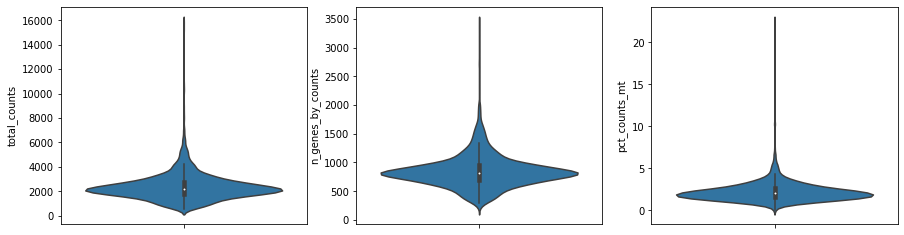

In [56]:
plot_violin(adata=andata)

## filter

In [57]:
st.preprocess.filter_cells(adata=andata, min_gene=200, n_genes_by_counts=3, pct_counts_mt=4, inplace=True)

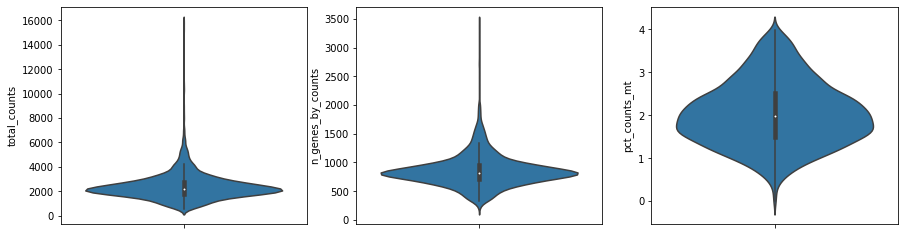

In [58]:
plot_violin(adata=andata)

## normalizer

In [59]:
normalizer = st.preprocess.Normalizer(data=andata, method='normalize_total', inplace=True, target_sum=10000)

In [60]:
nor_total = normalizer.fit()

In [13]:
normalizer.method = 'quantile'
nor_quantal = normalizer.fit()

## dim_reduce

In [61]:
# quantile_data = andata.copy()
# quantile_data.X = nor_quantal
dim_reduce = st.tools.DimReduce(andata=andata, method='pca', n_pcs=30, min_variance=0.01, n_iter=250, n_neighbors=10, min_dist=0.3, inplace=False, name='dim_reduce')
dim_reduce.fit()
pca_x = dim_reduce.result.x_reduce
# dim_reduce.method = 'tsen'
# dim_reduce.fit()
# tsen_x = dim_reduce.result.x_reduce
# dim_reduce.method = 'umap'
# dim_reduce.fit()
# umap_x = dim_reduce.result.x_reduce
# dim_reduce.mthod = 'low_variance'
# dim_reduce.fit()
# low_variance_x = dim_reduce.result.x_reduce
# dim_reduce.method = 'factor_analysis'
# dim_reduce.fit()
# factor = dim_reduce.result.x_reduce

## clustering

In [62]:
# dim_reduce.result.x_reduce = umap_x
cluster = st.tools.Clustering(data=andata, method='leiden', outdir=None, dim_reduce_key='dim_reduce', n_neighbors=30, normalize_key='cluster_normalize', normalize_method=None, nor_target_sum=10000, name='clustering')
cluster.fit()

{'0': '#ee82ee', '1': '#40e0d0', '2': '#ff6347', '3': '#008080', '4': '#d2b48c', '5': '#c0c0c0', '6': '#a0522d', '7': '#ff0000', '8': '#800080', '9': '#dda0dd', '10': '#ffc0cb', '11': '#da70d6', '12': '#ff4500', '13': '#ffa500', '14': '#808000', '15': '#000080', '16': '#800000', '17': '#ff00ff', '18': '#00ff00', '19': '#90ee90', '20': '#add8e6', '21': '#e6e6fa', '22': '#f0e68c', '23': '#4b0082', '24': '#808080', '25': '#008000', '26': '#ffd700', '27': '#ff00ff', '28': '#006400', '29': '#00008b', '30': '#00ffff', '31': '#dc143c', '32': '#ff7f50', '33': '#d2691e', '34': '#7fff00', '35': '#a52a2a', '36': '#0000ff', '37': '#000000', '38': '#f5f5dc', '39': '#f0ffff', '40': '#7fffd4', '41': '#00ffff'}


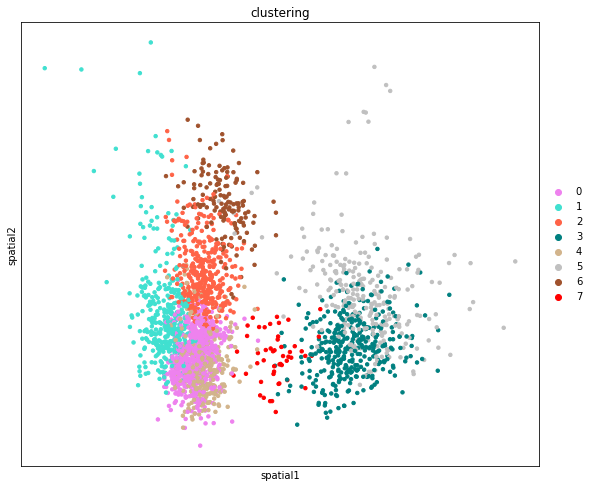

In [63]:
plot_cluster_result(adata=andata, obs_key=['clustering'], pos_key='dim_reduce')

## degs

In [64]:
marker = st.tools.FindMarker(data=andata, cluster='clustering', corr_method='bonferroni', method='t-test', name='marker_test')
marker.fit()

Find marker gene: 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


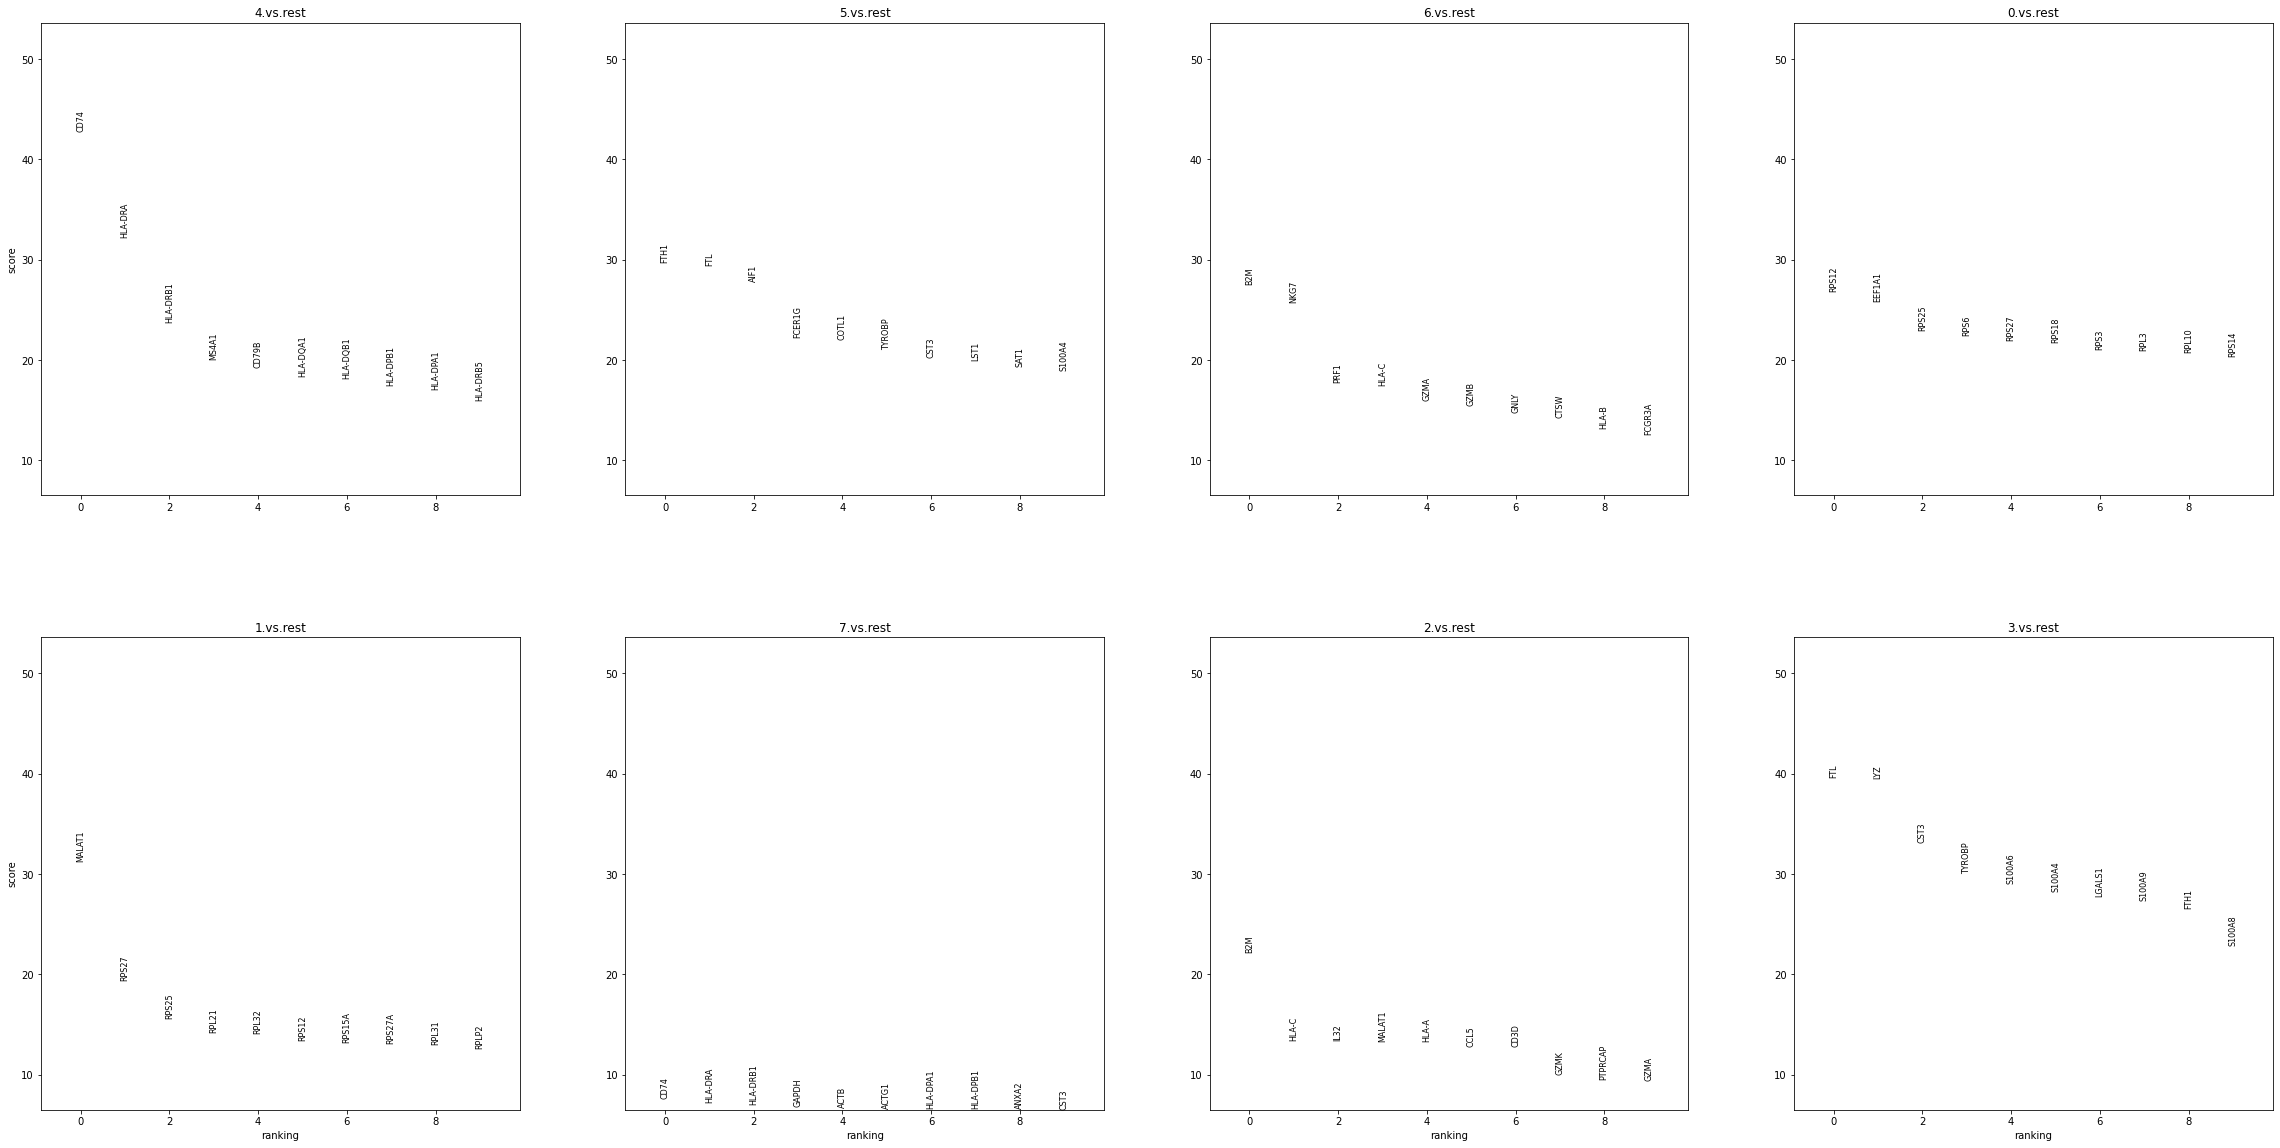

In [65]:
plot_degs(adata=andata, key = 'marker_test', n_genes=10)

## heatmap

(2563, 48)


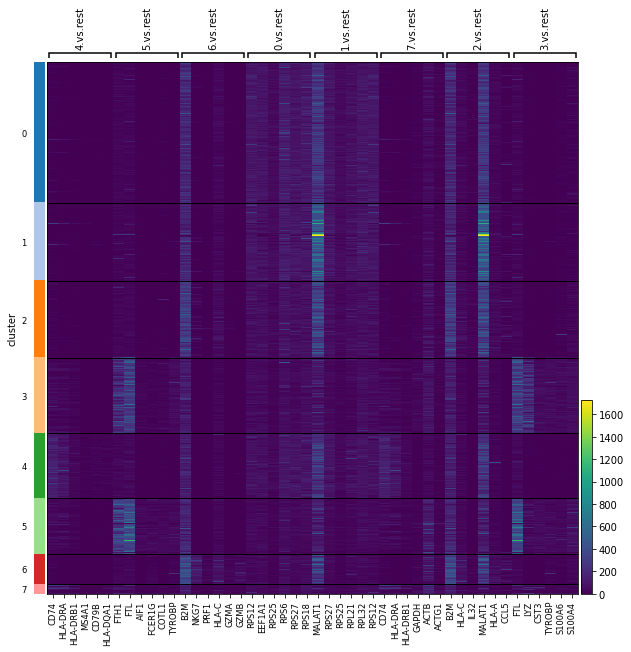

In [91]:

plot_heatmap_maker_genes(adata = andata,cluster_method="clustering", marker_uns_key="marker_test",num_show_gene=6)

# test embedding